In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid

data_dir = "mini_game_covers"

#We define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])



Using device: cpu


In [ ]:
#loading the dataset
import shutil
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
ImageFile.MAX_TEXT_CHUNK = 100 * (1024**2) # to increase the limit

checkpoint_path = "mini_game_covers/.ipynb_checkpoints"
if os.path.exists(checkpoint_path):
    shutil.rmtree(checkpoint_path)

dataset = ImageFolder("mini_game_covers", transform=transform)
classes = dataset.classes
print("Classes:", classes)

Classes: ['fighting', 'indie ', 'platform', 'puzzle', 'sport']


In [ ]:
#train/validation split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

class DeepMiniCNN(nn.Module):
    def __init__(self, num_classes):
        super(DeepMiniCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc(x)
        return x

model = DeepMiniCNN(len(classes)).to(device)

#Set Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
#training the model
train_acc, val_acc, train_loss_list = [], [], []

for epoch in range(20):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss_list.append(running_loss / len(train_loader))
    train_acc.append(100 * correct / total)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc.append(100 * correct / total)
    print(f"Epoch {epoch+1}: Train Acc = {train_acc[-1]:.2f}%, Val Acc = {val_acc[-1]:.2f}%, Loss = {train_loss_list[-1]:.4f}")


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1: Train Acc = 21.30%, Val Acc = 20.80%, Loss = 1.6092
Epoch 2: Train Acc = 24.95%, Val Acc = 26.00%, Loss = 1.5878
Epoch 3: Train Acc = 23.45%, Val Acc = 24.40%, Loss = 1.5872
Epoch 4: Train Acc = 26.10%, Val Acc = 27.00%, Loss = 1.5656
Epoch 5: Train Acc = 28.02%, Val Acc = 28.10%, Loss = 1.5473
Epoch 6: Train Acc = 28.50%, Val Acc = 31.70%, Loss = 1.5414
Epoch 7: Train Acc = 29.32%, Val Acc = 30.30%, Loss = 1.5378
Epoch 8: Train Acc = 30.82%, Val Acc = 30.60%, Loss = 1.5247
Epoch 9: Train Acc = 32.65%, Val Acc = 33.20%, Loss = 1.5087
Epoch 10: Train Acc = 33.25%, Val Acc = 31.80%, Loss = 1.4962
Epoch 11: Train Acc = 34.65%, Val Acc = 33.50%, Loss = 1.4827
Epoch 12: Train Acc = 35.35%, Val Acc = 32.00%, Loss = 1.4733
Epoch 13: Train Acc = 37.05%, Val Acc = 34.60%, Loss = 1.4427
Epoch 14: Train Acc = 37.92%, Val Acc = 31.90%, Loss = 1.4284
Epoch 15: Train Acc = 39.92%, Val Acc = 31.80%, Loss = 1.3801
Epoch 16: Train Acc = 42.40%, Val Acc = 31.40%, Loss = 1.3338
Epoch 17: Train A

In [ ]:
# Test Accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

final_test_accuracy = 100 * correct / total
print(f"Final Test Accuracy after 20 epochs: {final_test_accuracy:.2f}%")


Final Test Accuracy after 20 epochs: 24.80%


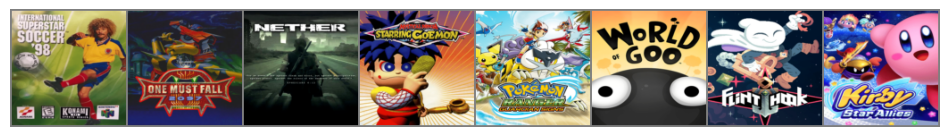

Predicted: ['fighting', 'platform', 'puzzle', 'puzzle', 'fighting', 'puzzle', 'platform', 'fighting']
Actual:    ['sport', 'fighting', 'sport', 'platform', 'sport', 'indie ', 'indie ', 'platform']


In [ ]:
# Show Predictions on Validation Set
import random

# Get a batch of validation data
dataiter = iter(val_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

images = images.cpu()
predicted = predicted.cpu()
labels = labels.cpu()

# Show 8 images
def show_images(imgs):
    imgs = imgs / 2 + 0.5  # unnormalize
    npimg = imgs.numpy()
    plt.figure(figsize=(12, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

show_images(torchvision.utils.make_grid(images[:8]))
print("Predicted:", [classes[predicted[j]] for j in range(8)])
print("Actual:   ", [classes[labels[j]] for j in range(8)])


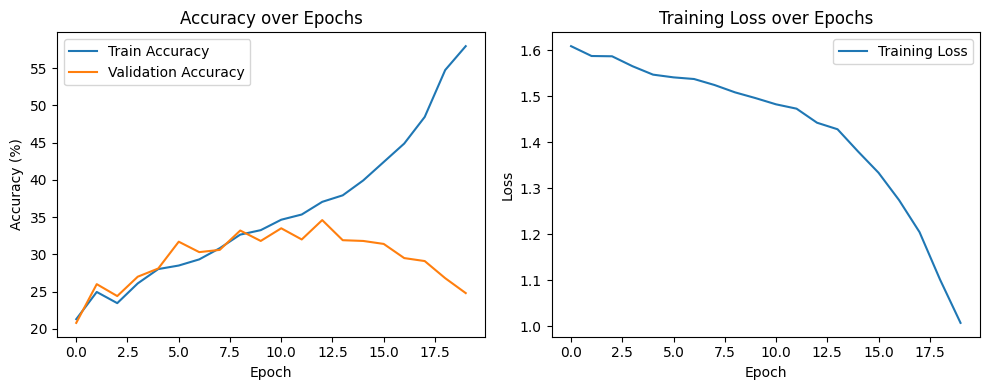

In [ ]:
# Plot Training/Validation Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plot Training Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# QUESTIONS

1. **What is a Convolutional Neural Network (CNN)? Describe its key components and how they differ from those in a fully connected neural network?**

*  A Convolutional Neural Network (CNN) is a sort of neural network applicable on image data particularly. CNNs have filters (kernels) instead of inter-linking all the neurons with all the pixels as in the fully connected networks to capture information, such as edges, textures, and shapes.

**##  Major elements of CNN:**

* Convolutional Layers: Represent the implementation of the learnable filters (kernels) to input images to identify features such as edges, shapes or texture. I applied 6 convolutional layers in my model with kernel size of 3x3, and padding of 1.

* ReLU Act I used ReLU all around the CNN.

* Pooling Layers: This is usually a max pooling, which is utilized to narrow the spatial dimensions of the features and avoid the overfitting. Mostly after convs I applied MaxPool2d (2).

* The fully connected networks are applied after the flattening in order to provide the final classification. I had a Linear(25688, 512) and a final Linear(512, 5) (because I had 5 different game genres).

* Softmax/Logits: To produce end predictions, and compute the loss in training.

**# CNNs would be more effective than the fully connected networks on an image since:**

* They decrease parameters number

* Maintain space relationships

2.** Explain the purpose of the convolution operation in a CNN. How does the use of different filter sizes affect the feature maps?**

* Convolution extracts spatial features of provided images. Every convolutional layer convolves a filter (which will be a 3x3 in my case) over the image and identifies a pattern such as edge, corner and shape. The resultant feature maps aid the model to learn how to compare between category.

The effects of the filter size:
* Fine details are detected using small filters (e.g. 3x3) and are computationally inexpensive.
* Bigger filters (e.g. 5x5, 7x7) take more area and could fail to find the small details but are computationally expensive.
* I employed the 3x3 filters in every layer of convolution in my project to facilitate the extraction of detailed features and control computation.

3.** What is the purpose of a pooling layer in a CNN, and how does it contribute to the network’s performance?**

* The pooling layers are employed to limit the space (width and height) of the feature maps whilst preserving the essential information. This helps:

* Minimize the parameter count
* Accelerate training
* Prevent overfitting
* Allow spatial invariance (spot patterns no matter where they are)

* After majority of convolutional layers, I applied MaxPool2d2 which retains most significant features within any 2x2 patch.

4. Why are activation functions important in CNNs? Compare the use of ReLU with other activation functions.

* The activation functions add non linearity to the model and the model can learn non-linear patterns, not only straight lines.

* I applied ReLU (Rectified Linear Unit) to each layer of the convolutional and dense layer. The popularity of ReLU is due to the reasons that:

* Implementation is easy
* Lowers the chances of exploding and vanishing gradients
* Is faster in contrast to sigmoid or tanh

**# Comparison:**

* The ReLU: f(x) = max(0,x) is quick and easy to compute
* Sigmoid: Skillets values to (0,1) but has the tendency of vanishing gradients
* Tanh: Crushes (-1,1), and is still subject to saturation

5. Describe the process of training a CNN. What are some common challenges faced during training?

# Training process:
* Load and preprocess data (resize, normalize)
* Forward pass: image to CNN then  prediction
* Compute loss (I used CrossEntropyLoss)
* Backward pass (gradient calculation)
* Optimizer updates weights (I used Adam)
* Repeat for several epochs

**#My setup:**
* Optimizer: Adam
* Epochs: 20
* Batch size: 64
* Dataset: Video Game Covers (5 classes)

**#Challenges I faced:**
* Low test accuracy (24.80%)
* Class imbalance (some classes may have more images)
* Visual variation in cover designs
* No data augmentation, which limited the model’s generalization

6. What are some common evaluation metrics used to assess the performance of a CNN on a classification task?

**#Metrics include:**
* Accuracy: % of correct predictions (used in this project)
* Loss: CrossEntropyLoss, shows how far off predictions are
* Precision, Recall, F1-score: useful when classes are imbalanced
* Confusion Matrix: gives a per-class breakdown of performance

**#In my project, I tracked:**
* Training Accuracy
* Validation Accuracy
* Training Loss
* Final Test Accuracy (24.80%)

7. How does data augmentation help improve the performance of a CNN? Provide examples of common data augmentation techniques.

* Data augmentation increases the diversity of training data by modifying images in real-time. This helps:
* Prevent overfitting
* Improve generalization
* Simulate real-world scenarios (rotated, flipped, etc.)

**#Common techniques:**
* Random crop
* Flip (horizontal/vertical)
* Color jitter
* Rotation, zoom

* In my case: I did not apply data augmentation to keep the training pipeline simple and focused on the CNN structure. However, the absence of augmentation likely contributed to the low test accuracy, as the model didn’t learn to generalize to unseen variations.


**Summary**

* I built a 6-layer CNN using PyTorch in Colab.

* Dataset: Custom small dataset of video game cover images (5 classes).

* No augmentation was used.

* Model was trained for 20 epochs on GPU.

* Final test accuracy: ~24.80%.

* This project gave me hands-on experience building and evaluating CNNs end-to-end.


